In [4]:
# Importing Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt # for plotting graphs

In [5]:
data = pd.read_csv(r'C:\Users\WIN 10\OneDrive\Desktop\New folder\Weekly-Submissions\Neural Networks From Scratch/train.csv')

In [6]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data.tail()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
data.shape

(42000, 785)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [11]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]

mean = np.mean(X_train, axis=1, keepdims=True)
std = np.std(X_train, axis=1, keepdims=True)
std[std == 0] = 1 # To prevent division by zero

X_dev = (X_dev - mean) / std
X_train = (X_train - mean) / std
_,m_train = X_train.shape

In [12]:
Y_train

array([9, 8, 9, ..., 9, 3, 0], dtype=int64)

In [16]:
# Starting Parameters (Initialization + 128 Hidden Units)
def init_params():
    W1 = np.random.randn(128, 784) * np.sqrt(2. / 784)
    b1 = np.zeros((128, 1))
    W2 = np.random.randn(10, 128) * np.sqrt(2. / 128)
    b2 = np.zeros((10, 1))
    return W1, b1, W2, b2

#Activations
def LeakyReLU(Z):
    Z = np.nan_to_num(Z)  
    return np.where(Z > 0, Z, 0.01 * Z)

def LeakyReLU_deriv(Z):
    return np.where(Z > 0, 1, 0.01)

    
def softmax(Z):
    A = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return A / np.sum(A, axis=0, keepdims=True)

# Forward Propagation
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) +  b1
    A1 = LeakyReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1,A1,Z2,A2

# One-hot Encoding    
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() +1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

# Backward Propagation
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = X.shape[1]
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * LeakyReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

# Update Parameters
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [17]:
# Predictions and Accuracy
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

# Training Loop
def gradient_descent_with_plot(X, Y, X_dev, Y_dev, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    train_accuracies = []
    dev_accuracies = []
    steps = []

    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if i % 10 == 0:
            train_pred = get_predictions(A2)
            train_acc = get_accuracy(train_pred, Y)
            train_accuracies.append(train_acc)

            Z1_dev, A1_dev, Z2_dev, A2_dev = forward_prop(W1, b1, W2, b2, X_dev)
            dev_pred = get_predictions(A2_dev)
            dev_acc = get_accuracy(dev_pred, Y_dev)
            dev_accuracies.append(dev_acc)

            steps.append(i)

            print(f"Iteration: {i}")
            print(f"Train Accuracy: {train_acc*100:.2f}%")
            print(f"Validation Accuracy: {dev_acc*100:.2f}%")
    
    # graph
    plt.figure(figsize=(10,6))
    plt.plot(steps, train_accuracies, label="Train Accuracy", color="crimson", linewidth=2)
    plt.plot(steps, dev_accuracies, label="Validation Accuracy", color="royalblue", linewidth=2)
    plt.title("Training & Validation Accuracy Over Iterations", fontsize=16)
    plt.xlabel("Iterations", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

    return W1, b1, W2, b2

Iteration: 0
Train Accuracy: 9.73%
Validation Accuracy: 9.30%
Iteration: 10
Train Accuracy: 13.26%
Validation Accuracy: 12.90%
Iteration: 20
Train Accuracy: 20.04%
Validation Accuracy: 21.60%
Iteration: 30
Train Accuracy: 30.41%
Validation Accuracy: 29.60%
Iteration: 40
Train Accuracy: 39.08%
Validation Accuracy: 37.70%
Iteration: 50
Train Accuracy: 46.25%
Validation Accuracy: 44.50%
Iteration: 60
Train Accuracy: 52.01%
Validation Accuracy: 49.90%
Iteration: 70
Train Accuracy: 56.68%
Validation Accuracy: 53.70%
Iteration: 80
Train Accuracy: 60.43%
Validation Accuracy: 57.20%
Iteration: 90
Train Accuracy: 63.41%
Validation Accuracy: 60.60%
Iteration: 100
Train Accuracy: 65.88%
Validation Accuracy: 62.80%
Iteration: 110
Train Accuracy: 68.08%
Validation Accuracy: 65.30%
Iteration: 120
Train Accuracy: 69.83%
Validation Accuracy: 67.30%
Iteration: 130
Train Accuracy: 71.40%
Validation Accuracy: 68.00%
Iteration: 140
Train Accuracy: 72.68%
Validation Accuracy: 69.90%
Iteration: 150
Train Ac

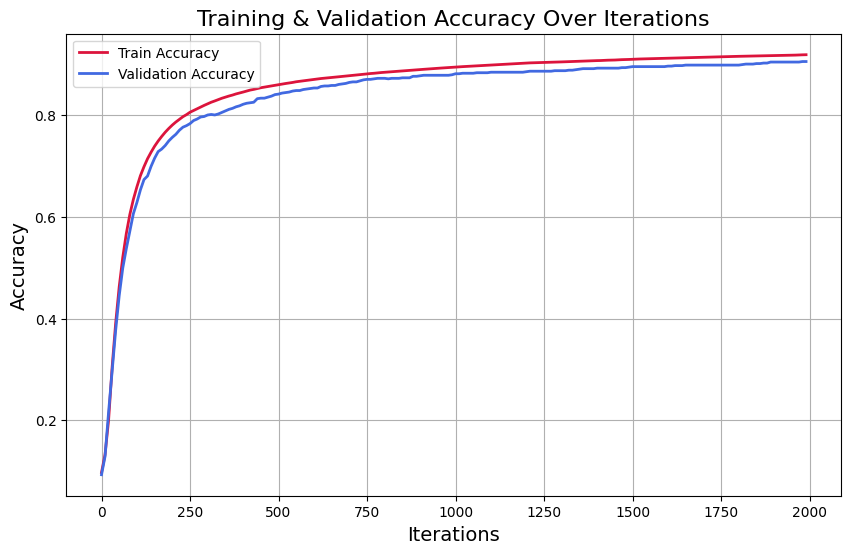

In [18]:
W1, b1, W2, b2 = gradient_descent_with_plot(X_train, Y_train, X_dev, Y_dev, alpha=0.005, iterations=2000)
